# Face Detection

In [1]:
import os
import datetime
import cv2 as cv
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2023-02-14 17:02:00.809994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 17:02:00.915126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 17:02:00.916090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Utility Functions

In [3]:
INPUT_BASE_PATH = ''
OUTPUT_BASE_PATH = ''
RAW_IMAGES_PATH = INPUT_BASE_PATH + 'raw/images/'
RAW_LABELS_PATH = INPUT_BASE_PATH + 'raw/labels/'
AUG_IMAGES_PATH = OUTPUT_BASE_PATH + 'aug/images/'
AUG_LABELS_PATH = OUTPUT_BASE_PATH + 'aug/labels/'
TRAIN_IMAGES_PATH = OUTPUT_BASE_PATH + 'train/images/'
TRAIN_LABELS_PATH = OUTPUT_BASE_PATH + 'train/labels/'
TEST_IMAGES_PATH = OUTPUT_BASE_PATH + 'test/images/'
TEST_LABELS_PATH = OUTPUT_BASE_PATH + 'test/labels/'

BATCH_SIZE = 32

Creating folders for working if not exists

In [4]:
folders = [AUG_IMAGES_PATH, AUG_LABELS_PATH, TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH, TEST_IMAGES_PATH, TEST_LABELS_PATH]

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [5]:
def get_image_tensor(image_location):
    """Returns a tensorflow decoded image
    """
    image = tf.io.read_file(image_location)
    image = tf.io.decode_jpeg(image, channels=3)
    return image

In [6]:
def get_opp_points(x, y, height, width, image_size=450, normalized=False):
    """ Changes (x_center, y_center, height, width) to (x_min, y_min, x_max, y_max)
    """
    x1 = x - (height / 2)
    y1 = y - (width / 2)
    x2 = x + (height / 2)
    y2 = y + (width / 2)
    
    if not normalized:
        p1 = tuple(np.multiply((x1, y1), image_size).astype(int))
        p2 = tuple(np.multiply((x2, y2), image_size).astype(int))
        return p1, p2
    
    return (x1, y1, x2, y2)

In [7]:
def get_label_data(label_location):
    """Returns a formated label data from the given location.
    """
    if os.path.exists(label_location):
        with open(label_location, 'r') as file:
            p = list(map(float, file.read().split()))
            return p[1:]
    else:
        return None

# Importing Data

In [56]:
# A list for maintaing data name
data_items = []

for name in os.listdir(RAW_IMAGES_PATH):
    data_items.append(os.path.splitext(name)[0])

In [57]:
len(data_items)

120

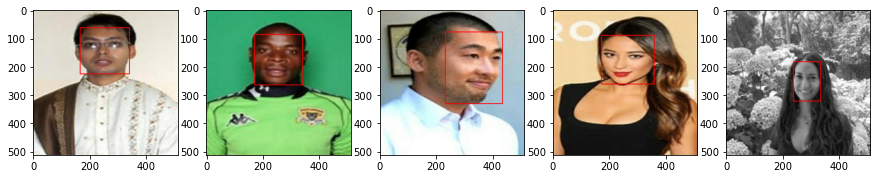

In [90]:
fig, ax = plt.subplots(ncols=5, figsize=(15, 10))
for ax_index in range(5):
    index = np.random.randint(low=0, high=len(data_items) - 1)
    
    img_loc = RAW_IMAGES_PATH + data_items[index] + '.jpeg'
    label_loc = RAW_LABELS_PATH + data_items[index] + '.txt'
    
    image = get_image_tensor(img_loc).numpy()
    labels = get_label_data(label_loc)
    
    if labels is not None:
        bbox = get_opp_points(*labels, image_size=512)
        cv.rectangle(image, *bbox, (255, 0, 0), 2)
    
    ax[ax_index].imshow(image)

In [11]:
images = tf.data.Dataset.list_files(RAW_IMAGES_PATH + '*')

In [12]:
get_image_tensor(images.as_numpy_iterator().next()).shape

TensorShape([512, 512, 3])

# Data Augmentation

In [13]:
import albumentations as A

In [14]:
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(),
    A.RGBShift(),
    A.ISONoise(p=0.2, intensity=(0.1, 0.3)),
    A.Sharpen(p=0.2, alpha=(0.51, 1.0)),
    A.RandomToneCurve(p=0.7)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [15]:
image = get_image_tensor(RAW_IMAGES_PATH + '66241279-941a-4989-bb23-c68c2d1bfe31.jpeg').numpy()
l = get_label_data(RAW_LABELS_PATH + '66241279-941a-4989-bb23-c68c2d1bfe31.txt')

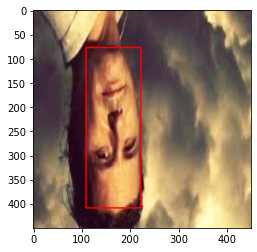

In [16]:
transformed = transform(image=image, bboxes=[l], class_labels=['Face'])

bbox = get_opp_points(*transformed['bboxes'][0])

cv.rectangle(
    transformed['image'],
    *bbox,
    (255, 0, 0),
    2
)
plt.imshow(transformed['image'])

In [17]:
for name in data_items:
    image_path = RAW_IMAGES_PATH + name + '.jpeg'
    label_path = RAW_LABELS_PATH + name + '.txt'
        
    # Image Matrix
    image = get_image_tensor(image_path).numpy()
    
    # Label - Defaults to 0 when unlabeled
    label = get_label_data(label_path)
    if label is None:
        label = [0.0001, 0.0001, 0.0001,  0.0001]
        
    for i in range(50):
        new_name = name + f'-{i}'
        
        # Augmenting
        transformed = transform(image=image, bboxes=[label], class_labels=['Face'])

        # Saving the image
        cv.imwrite(AUG_IMAGES_PATH + new_name + '.jpeg', transformed['image'])
        
        # Saving the label
        bbox = transformed['bboxes']
        if len(bbox) == 1:
            bbox = list(bbox[0])
            bbox.insert(0, 1)
        else:
            bbox = list(label)
            bbox.insert(0, 0)
        
        with open(AUG_LABELS_PATH + new_name + '.txt', 'w') as file:
            file.write(' '.join([str(x) for x in bbox]))

# Train and Test Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
data_items = []

for name in os.listdir(AUG_IMAGES_PATH):
    data_items.append(os.path.splitext(name)[0])

In [20]:
len(data_items)

6000

Data is split as 85% for training and 15% for testing

In [21]:
train, test = train_test_split(data_items, test_size=0.15, random_state=0)

In [22]:
len(train), len(test)

(5100, 900)

Moving data into their respective folders

In [23]:
import shutil

In [24]:
def save_data(data_item, train=True):
    old_image_path = AUG_IMAGES_PATH + data_item + '.jpeg'
    old_label_path = AUG_LABELS_PATH + data_item + '.txt'
    
    if train:
        new_image_path = TRAIN_IMAGES_PATH + data_item + '.jpeg'
        new_label_path = TRAIN_LABELS_PATH + data_item + '.txt'
    else:
        new_image_path = TEST_IMAGES_PATH + data_item + '.jpeg'
        new_label_path = TEST_LABELS_PATH + data_item + '.txt'
    
    shutil.copy(old_image_path, new_image_path)
    shutil.copy(old_label_path, new_label_path)

In [25]:
for i in train:
    save_data(i, train=True)
for i in test:
    save_data(i, train=False)

In [26]:
def get_label_tensor(label_path):
    """Converts a label to its respective formats
    """
    with open(label_path.numpy(), 'r') as file:
        data = file.read()
        data = data.split()
        data = list(map(float, data))
    return int(data[0]), tf.constant(data[1:])

Importing training and testing images and resizing them to 256 pixels

In [27]:
train_images = tf.data.Dataset.list_files(TRAIN_IMAGES_PATH + '*', shuffle=False)
train_images = train_images.map(get_image_tensor)
train_images = train_images.map(lambda x: tf.image.resize(x, (256, 256)))
train_images = train_images.map(lambda x: x / 256)

In [28]:
test_images = tf.data.Dataset.list_files(TEST_IMAGES_PATH + '*', shuffle=False)
test_images = test_images.map(get_image_tensor)
test_images = test_images.map(lambda x: tf.image.resize(x, (256, 256)))
test_images = test_images.map(lambda x: x / 256)

Importing training and testing labels and converting them to their respective formats

In [29]:
train_labels = tf.data.Dataset.list_files(TRAIN_LABELS_PATH + '*', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(get_label_tensor, [x], [tf.uint32, tf.float32]))

In [30]:
test_labels = tf.data.Dataset.list_files(TEST_LABELS_PATH + '*', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(get_label_tensor, [x], [tf.uint32, tf.float32]))

Zipping images and labels together

In [31]:
train_data = tf.data.Dataset.zip((train_images, train_labels)).shuffle(200).batch(BATCH_SIZE)
test_data = tf.data.Dataset.zip((test_images, test_labels)).shuffle(200).batch(BATCH_SIZE)

In [32]:
len(train_data), len(test_data)

(160, 29)

# Model

In [33]:
tf.keras.applications.vgg16.VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [34]:
class FaceDetection(tf.keras.Model):
    """
        A custom model for face detection based on VGG16
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.vgg_model = tf.keras.applications.vgg16.VGG16(include_top=False)
        self.model = self._create_model()
    
    
    def compile(self, **kwargs):
        super().compile(**kwargs)
        self._optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self._class_loss = tf.keras.losses.BinaryCrossentropy()    
    
    def _bbox_loss(self, actual, predicted):
        delta_coord = tf.reduce_sum(tf.square(actual[:, :2] - predicted[:, :2]))
                  
        h_true = actual[:, 3] - actual[:, 1] 
        w_true = actual[:, 2] - actual[:, 0] 

        h_pred = predicted[:, 3] - predicted[:, 1] 
        w_pred = predicted[:, 2] - predicted[:, 0] 

        delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

        return delta_coord + delta_size
       
    
    def train_step(self, batch, **kwargs):
        X, y = batch
        with tf.GradientTape() as tape:
            class_pred, regres_pred = self.model(X, training=True)
            class_loss = self._class_loss(y[0], class_pred)
            regres_loss = self._bbox_loss(y[1], regres_pred)
            total_loss = (class_loss + regres_loss) / 2
            g = tape.gradient(total_loss, model.trainable_variables)
        self._optimizer.apply_gradients(zip(g, model.trainable_variables))
        return {'class_loss': class_loss, 'regres_loss': regres_loss, 'total_loss': total_loss}
        
        
    def test_step(self, batch, **kwargs):
        X, y = batch
        class_pred, regres_pred = self.model(X, training=False)
        class_loss = self._class_loss(y[0], class_pred)
        regres_loss = self._bbox_loss(tf.cast(y[1], tf.float32), regres_pred)
        total_loss = (class_loss + regres_loss) / 2
        return {'class_loss': class_loss, 'regres_loss': regres_loss, 'total_loss': total_loss}
    
    def _create_model(self):
        input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
        
        # Freezing VGG Model
        self.vgg_model.trainable = False
        
        vgg = self.vgg_model(input_layer)
        
        # Classification Network -> Face Classification
        cl1 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
        cl2 = tf.keras.layers.Flatten()(cl1)
        cl3 = tf.keras.layers.Dense(512, activation='relu')(cl2)
        cl4 = tf.keras.layers.Dense(128, activation='relu')(cl3)
        cl5 = tf.keras.layers.Dense(1, activation='sigmoid')(cl4)
        
        # Regression Network -> Bounding Box Prediction
        cr1 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
        cr2 = tf.keras.layers.Flatten()(cr1)
        cr3 = tf.keras.layers.Dense(512, activation='relu')(cr2)
        cr4 = tf.keras.layers.Dense(128, activation='relu')(cr3)
        cr5 = tf.keras.layers.Dense(64, activation='relu')(cr4)
        cr6 = tf.keras.layers.Dense(4, activation='sigmoid')(cr5)
        
        # Creating a keras model
        model = tf.keras.Model(inputs=input_layer, outputs=[cl5, cr6], name='FaceDetector')
        
        return model
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [35]:
model = FaceDetection()

In [36]:
model.compile()

Fitting the model with 64 epochs

In [37]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=100
)

Epoch 1/100


2023-02-14 17:08:40.994772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-14 17:08:42.806082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 [==============================] - 44s 202ms/step - class_loss: 0.1511 - regres_loss: 3.6056 - total_loss: 1.8783 - val_class_loss: 6.8025e-04 - val_regres_loss: 0.0945 - val_total_loss: 0.0476
Epoch 2/100
160/160 [==============================] - 28s 174ms/step - class_loss: 0.0073 - regres_loss: 2.0960 - total_loss: 1.0516 - val_class_loss: 3.0505e-04 - val_regres_loss: 0.2951 - val_total_loss: 0.1477
Epoch 3/100
160/160 [==============================] - 31s 190ms/step - class_loss: 0.0051 - regres_loss: 1.5339 - total_loss: 0.7695 - val_class_loss: 7.0537e-05 - val_regres_loss: 0.1664 - val_total_loss: 0.0832
Epoch 4/100
160/160 [==============================] - 31s 190ms/step - class_loss: 6.2273e-04 - regres_loss: 1.2590 - total_loss: 0.6298 - val_class_loss: 2.7870e-04 - val_regres_loss: 0.1817 - val_total_loss: 0.0910
Epoch 5/100
160/160 [==============================] - 30s 186ms/step - class_loss: 1.8324e-04 - regres_loss: 1.0921 - total_loss: 0.5461 - val_class_lo

Model Training Graph

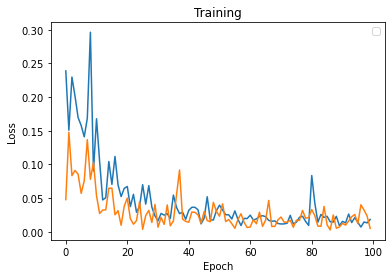

In [38]:
plt.plot(history.history['total_loss'])
plt.plot(history.history['val_total_loss'])
plt.title('Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Testing

In [39]:
t = test_data.as_numpy_iterator()

In [91]:
td = t.next()[0]
pred = model.predict(td)

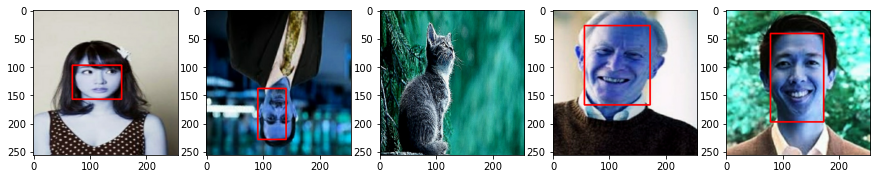

In [92]:
fig, ax = plt.subplots(ncols=5, figsize=(15, 10))
for ax_index in range(5):    
    image = td[ax_index]

    if pred[0][ax_index] > 0.8:
        bbox = get_opp_points(*pred[1][ax_index], image_size=256)
        cv.rectangle(image, *bbox, (255, 0, 0), 2)

    ax[ax_index].imshow(image)

In [93]:
model.save_weights(OUTPUT_BASE_PATH + 'weights.h5')